<a href="https://colab.research.google.com/github/mrpranavr/Corona-prediction-deep-model/blob/main/Corona_prediction_KERALA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Kerala Dataset

## Data preprocessing

In [ ]:
import pandas as pd
kerala_df = pd.read_csv('/content/kerala.csv',)
kerala_df.head()

,date,Cases
0,01-06-2020,57
1,02-06-2020,86
2,03-06-2020,82
3,04-06-2020,94
4,05-06-2020,111


In [ ]:
kerala_df['date'] = pd.to_datetime(kerala_df['date'], format = '%d-%m-%Y')
kerala_df.head()

,date,Cases
0,2020-06-01,57
1,2020-06-02,86
2,2020-06-03,82
3,2020-06-04,94
4,2020-06-05,111


In [ ]:
kerala_df = kerala_df.set_index('date')
kerala_df.head()

,Cases
date,
2020-06-01,57
2020-06-02,86
2020-06-03,82
2020-06-04,94
2020-06-05,111


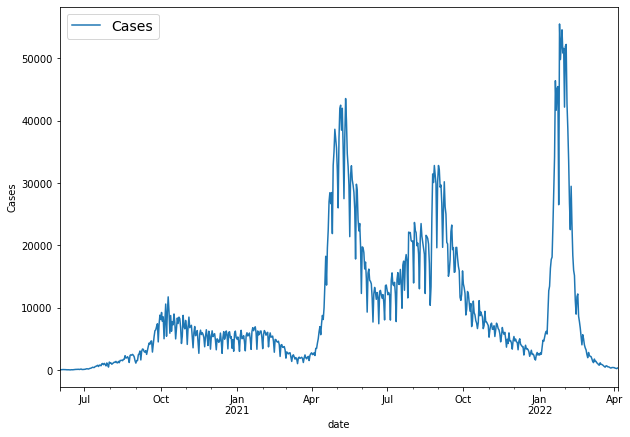

In [ ]:
kerala_df.plot(figsize = (10,7))
plt.ylabel("Cases")
plt.legend(fontsize = 14);

In [ ]:
kerala_df[:10]

,Cases
date,
2020-06-01,57
2020-06-02,86
2020-06-03,82
2020-06-04,94
2020-06-05,111
2020-06-06,108
2020-06-07,107
2020-06-08,91
2020-06-09,91


## Windowing dataset

In [ ]:
timesteps = kerala_df.index.to_numpy()
cases = kerala_df['Cases'].to_numpy()
cases = cases.astype(np.float32)

timesteps[:10], cases[:10]

(array(['2020-06-01T00:00:00.000000000', '2020-06-02T00:00:00.000000000',
        '2020-06-03T00:00:00.000000000', '2020-06-04T00:00:00.000000000',
        '2020-06-05T00:00:00.000000000', '2020-06-06T00:00:00.000000000',
        '2020-06-07T00:00:00.000000000', '2020-06-08T00:00:00.000000000',
        '2020-06-09T00:00:00.000000000', '2020-06-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([ 57.,  86.,  82.,  94., 111., 108., 107.,  91.,  91.,  65.],
       dtype=float32))

In [ ]:
split_size = int(len(cases)*0.8)
X_train,y_train = timesteps[:split_size], cases[:split_size]
X_test,y_test = timesteps[split_size:], cases[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(539, 135, 539, 135)

In [ ]:
def plot_time_series(timesteps,values,format = '.', start = 0,end = None,label = None):
    plt.plot(timesteps[start:end], values[start:end], format , label = label)
    plt.xlabel("Time")
    plt.ylabel("Cases")
    if label:
        plt.legend(fontsize = 14)
    plt.grid();

In [ ]:
def evaluate_preds(y_true,y_pred):
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy()}

In [ ]:
# Declare constants
HORIZON = 7
WINDOW_SIZE = 7


## Creating the prepricessing functions

In [ ]:
def get_labelled_window(x,horizon = HORIZON):
    return x[:,:-horizon], x[:,-horizon:]

In [ ]:
def make_windows(x,window_size = 7,horizon = 1):
    window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon+1)),axis = 0).T
    windowed_array = x[window_indexes]
    windows,labels = get_labelled_window(windowed_array,horizon = horizon)
    return windows, labels

In [ ]:
full_windows,full_labels = make_windows(cases,window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(659, 659)

In [ ]:
# Visualize the data
for i in range(5):
    print(f"Windows : {full_windows[i]} -> Label: {full_labels[i]}")

Windows : [ 57.  86.  82.  94. 111. 108. 107.] -> Label: [91. 91. 65. 83. 78. 85. 54.]
Windows : [ 86.  82.  94. 111. 108. 107.  91.] -> Label: [91. 65. 83. 78. 85. 54. 82.]
Windows : [ 82.  94. 111. 108. 107.  91.  91.] -> Label: [65. 83. 78. 85. 54. 82. 79.]
Windows : [ 94. 111. 108. 107.  91.  91.  65.] -> Label: [83. 78. 85. 54. 82. 79. 75.]
Windows : [111. 108. 107.  91.  91.  65.  83.] -> Label: [78. 85. 54. 82. 79. 75. 97.]


In [ ]:
def make_train_test_split(windows,labels,test_split = 0.2):
    split_size = int(len(windows)*(1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows,test_windows,train_labels,test_labels

In [ ]:
# Make the train and test datasets
train_windows, test_windows, train_labels,test_labels = make_train_test_split(full_windows,full_labels, test_split = 0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(527, 132, 527, 132)

In [ ]:
# Making model checkpoint callback
def create_model_checkpoint(model_name, save_path = "model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path,model_name),
                                              verbose = 0,
                                              save_best_only = True)

In [ ]:
def make_preds(model_name, test_dataset):
    preds = model_name.predict(test_dataset)
    return tf.squeeze(preds)

## MODEL 1 : Conv1D (windows_size = 7, horizon = 7)

In [ ]:
from tensorflow.keras import layers

In [ ]:
# Set random seed
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,axis = 1)),
    layers.Conv1D(filters = 128, kernel_size = 5, padding = 'causal',activation = 'relu'),
    layers.Dense(HORIZON)
],name = 'model_1_Conv1D')

model_1.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

model_1.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 32,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_1.name)])

Epoch 1/100
17/17 [==============================] - 11s 76ms/step - loss: 8492.1865 - val_loss: 7910.3945
Epoch 2/100
17/17 [==============================] - 1s 56ms/step - loss: 7904.7988 - val_loss: 7472.5996
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 7878.0801 - val_loss: 7662.0723
Epoch 4/100
17/17 [==============================] - 0s 7ms/step - loss: 7884.3687 - val_loss: 7754.1353
Epoch 5/100
17/17 [==============================] - 0s 7ms/step - loss: 7851.5493 - val_loss: 7642.5728
Epoch 6/100
17/17 [==============================] - 0s 8ms/step - loss: 7846.2251 - val_loss: 7619.5063
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 7846.6538 - val_loss: 7614.8486
Epoch 8/100
17/17 [==============================] - 0s 7ms/step - loss: 7907.0679 - val_loss: 7733.6919
Epoch 9/100
17/17 [==============================] - 0s 7ms/step - loss: 7870.8916 - val_loss: 7638.0249
Epoch 10/100
17/17 [==============================] 

In [ ]:
model_1.evaluate(test_windows,test_labels)

5/5 [==============================] - 0s 4ms/step - loss: 7747.4282


7747.42822265625

In [ ]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_Conv1D')
model_1.evaluate(test_windows,test_labels)

5/5 [==============================] - 0s 5ms/step - loss: 7472.5996


7472.599609375

In [ ]:
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]

<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[3526.2507, 2941.171 , 2861.777 , 2985.407 , 3085.2578, 3043.3003,
        3026.4604],
       [3391.7449, 2943.9697, 2958.486 , 2775.9443, 3323.784 , 3148.158 ,
        2956.651 ],
       [3157.429 , 3041.9548, 3106.066 , 2692.1387, 3297.01  , 3115.7927,
        2950.8926],
       [3149.1904, 2892.4014, 2961.6355, 2783.9453, 3084.6492, 2822.635 ,
        2971.2446],
       [3056.1218, 2748.309 , 2947.1467, 2905.2195, 3001.0608, 2787.327 ,
        2994.04  ],
       [3026.3206, 2750.6824, 3072.4062, 2836.244 , 2827.4878, 2877.3223,
        2911.7996],
       [3104.4534, 2716.2698, 2768.8477, 2728.419 , 2646.0415, 2690.9937,
        2783.645 ],
       [3123.7976, 2540.9397, 2450.3755, 2646.322 , 2708.4539, 2647.3262,
        2666.6787],
       [2786.0325, 2498.1387, 2451.0269, 2383.8162, 2673.2742, 2679.6858,
        2526.8088],
       [2846.868 , 2462.9016, 2524.4531, 2295.15  , 2715.8054, 2574.7122,
        2381.136 ]], dtype=floa

In [ ]:
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_1_preds)
model_1_results

{'mae': 5806.5747, 'mape': 40.38666, 'mse': 133524930.0, 'rmse': 6193.2124}

## MODEL - 2 : Conv-1D (windows_size = 14, horizon = 7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 14

In [ ]:
full_windows,full_labels = make_windows(cases, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(652, 652)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(521, 131, 521, 131)

In [ ]:
# Making model
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,axis = 1)),
    layers.Conv1D(filters = 128,kernel_size = 5,padding = 'causal',activation = 'relu'),
    layers.Dense(HORIZON)
],name = 'model_2_Conv1D_14_7')

model_2.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 32,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_2.name)])

Epoch 1/100
17/17 [==============================] - 2s 69ms/step - loss: 8346.3184 - val_loss: 7595.8877
Epoch 2/100
17/17 [==============================] - 0s 7ms/step - loss: 7868.0635 - val_loss: 7787.2817
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 7937.8521 - val_loss: 7855.3716
Epoch 4/100
17/17 [==============================] - 0s 7ms/step - loss: 7867.9424 - val_loss: 7717.0835
Epoch 5/100
17/17 [==============================] - 0s 7ms/step - loss: 7890.5117 - val_loss: 7860.8081
Epoch 6/100
17/17 [==============================] - 0s 7ms/step - loss: 7904.4946 - val_loss: 7787.1011
Epoch 7/100
17/17 [==============================] - 0s 7ms/step - loss: 7883.1494 - val_loss: 7796.1504
Epoch 8/100
17/17 [==============================] - 0s 8ms/step - loss: 7909.3960 - val_loss: 7819.9194
Epoch 9/100
17/17 [==============================] - 0s 7ms/step - loss: 7851.6636 - val_loss: 7743.2979
Epoch 10/100
17/17 [==============================] - 

In [ ]:
model_2.evaluate(test_windows,test_labels)

5/5 [==============================] - 0s 5ms/step - loss: 8115.6631


8115.6630859375

In [ ]:
model_2 = tf.keras.models.load_model('model_experiments/model_2_Conv1D_14_7')
model_2.evaluate(test_windows, test_labels)

5/5 [==============================] - 0s 6ms/step - loss: 7566.8555


7566.85546875

In [ ]:
model_2_preds = make_preds(model_2, test_windows)
model_2_preds[:10]

<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[3596.1084, 3621.1711, 3533.5203, 3695.2131, 3583.9492, 3759.1414,
        3701.6973],
       [3261.6233, 3365.179 , 3308.3145, 3486.5457, 3236.181 , 3421.7922,
        3521.4854],
       [3240.478 , 3177.669 , 3134.234 , 3197.8906, 3208.974 , 3170.5806,
        3276.721 ],
       [3753.632 , 3657.9106, 3600.3164, 3695.0479, 3637.834 , 3769.526 ,
        3703.0828],
       [3523.5317, 3490.1982, 3541.2383, 3605.157 , 3539.6243, 3574.4915,
        3650.4944],
       [2966.847 , 2990.0815, 2957.945 , 3006.7983, 2977.9316, 2961.8381,
        3017.8477],
       [3234.0413, 3153.993 , 3124.083 , 3243.838 , 3151.966 , 3233.069 ,
        3108.3098],
       [2942.5713, 3042.1575, 2814.2473, 3040.2578, 2892.481 , 3006.785 ,
        3007.3232],
       [2951.2861, 2991.9417, 3003.7883, 3098.775 , 3009.7542, 3096.0261,
        3151.8513],
       [2699.5515, 2632.722 , 2631.3047, 2700.7217, 2631.1272, 2709.4934,
        2755.499 ]], dtype=floa

In [ ]:
test_labels[:5]

array([[6111., 5754., 6075., 5080., 3698., 4972., 4280.],
       [5754., 6075., 5080., 3698., 4972., 4280., 5987.],
       [6075., 5080., 3698., 4972., 4280., 5987., 4677.],
       [5080., 3698., 4972., 4280., 5987., 4677., 4741.],
       [3698., 4972., 4280., 5987., 4677., 4741., 4350.]], dtype=float32)

In [ ]:
model_2_results = evaluate_preds(y_true= tf.squeeze(test_labels),
                                 y_pred = model_2_preds)
model_2_results

{'mae': 6364.078, 'mape': 46.891693, 'mse': 152749060.0, 'rmse': 6789.318}

In [ ]:
model_1_results

{'mae': 5806.5747, 'mape': 40.38666, 'mse': 133524930.0, 'rmse': 6193.2124}

## MODEL X: Conv1D (window_size = 7, horizon = 1)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
full_windows,full_labels = make_windows(cases, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(665, 665)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(532, 133, 532, 133)

In [ ]:
tf.random.set_seed(42)

model_X = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,axis = 1)),
    layers.Conv1D(filters = 128,kernel_size = 5,padding = 'causal',activation = 'relu'),
    layers.Dense(HORIZON)
],name = 'model_X_Conv1D_7_1')

model_X.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

model_X.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 32,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_X.name)])

Epoch 1/100
17/17 [==============================] - 2s 66ms/step - loss: 4036.4836 - val_loss: 3556.9412
Epoch 2/100
17/17 [==============================] - 1s 54ms/step - loss: 1792.3114 - val_loss: 3163.6794
Epoch 3/100
17/17 [==============================] - 0s 8ms/step - loss: 1619.1373 - val_loss: 3250.3611
Epoch 4/100
17/17 [==============================] - 1s 52ms/step - loss: 1520.0876 - val_loss: 3157.7268
Epoch 5/100
17/17 [==============================] - 0s 7ms/step - loss: 1523.4635 - val_loss: 3188.7358
Epoch 6/100
17/17 [==============================] - 1s 66ms/step - loss: 1496.6136 - val_loss: 3139.9646
Epoch 7/100
17/17 [==============================] - 1s 54ms/step - loss: 1483.0325 - val_loss: 3095.8638
Epoch 8/100
17/17 [==============================] - 0s 8ms/step - loss: 1471.0737 - val_loss: 3106.5613
Epoch 9/100
17/17 [==============================] - 0s 7ms/step - loss: 1459.1927 - val_loss: 3101.1521
Epoch 10/100
17/17 [==============================

In [ ]:
model_X = tf.keras.models.load_model('model_experiments/model_X_Conv1D_7_1')
model_X.evaluate(test_windows,test_labels)

5/5 [==============================] - 0s 4ms/step - loss: 2630.5574


2630.557373046875

## MODEL 3 : LSTM (window_size = 7, horizon = 7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 7 

In [ ]:
full_windows,full_labels = make_windows(cases, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(659, 659)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(527, 132, 527, 132)

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape = (WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x,axis = 1))(inputs)
# x = layers.LSTM(128, activation = 'relu', return_sequences = True)(x)
x = layers.LSTM(128, activation = 'relu')(x)
# x = layers.Dense(128,activation = 'relu')(x)
outputs = layers.Dense(HORIZON)(x)
model_3 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'model_3_LSTM')

model_3.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 32,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_3.name)])

Epoch 1/100
15/17 [=========================>....] - ETA: 0s - loss: 9290.5684INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 5s 189ms/step - loss: 9166.8994 - val_loss: 9248.5371
Epoch 2/100
14/17 [=======================>......] - ETA: 0s - loss: 7224.5591INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 152ms/step - loss: 6928.4077 - val_loss: 6759.2397
Epoch 3/100
13/17 [=====================>........] - ETA: 0s - loss: 4458.7715INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 153ms/step - loss: 4101.1416 - val_loss: 5783.4697
Epoch 4/100
15/17 [=========================>....] - ETA: 0s - loss: 2429.9758INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 3s 164ms/step - loss: 2414.1262 - val_loss: 5540.0405
Epoch 5/100
14/17 [=======================>......] - ETA: 0s - loss: 2234.1626INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 150ms/step - loss: 2155.6558 - val_loss: 5280.9385
Epoch 6/100
14/17 [=======================>......] - ETA: 0s - loss: 2085.3823INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 146ms/step - loss: 2070.3923 - val_loss: 5123.6572
Epoch 7/100
14/17 [=======================>......] - ETA: 0s - loss: 2045.5677INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 149ms/step - loss: 2039.6776 - val_loss: 5054.3428
Epoch 8/100
13/17 [=====================>........] - ETA: 0s - loss: 2024.2585INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 3s 170ms/step - loss: 1989.9995 - val_loss: 4908.4609
Epoch 9/100
13/17 [=====================>........] - ETA: 0s - loss: 2055.4036INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 149ms/step - loss: 1997.4896 - val_loss: 4772.1709
Epoch 10/100
17/17 [==============================] - 0s 12ms/step - loss: 2031.7799 - val_loss: 4952.4526
Epoch 11/100
17/17 [==============================] - 0s 11ms/step - loss: 2029.5486 - val_loss: 4915.0513
Epoch 12/100
17/17 [==============================] - 0s 11ms/step - loss: 1993.3063 - val_loss: 4846.8989
Epoch 13/100
12/17 [====================>.........] - ETA: 0s - loss: 1989.7745INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 149ms/step - loss: 1984.8547 - val_loss: 4721.5366
Epoch 14/100
13/17 [=====================>........] - ETA: 0s - loss: 1954.3260INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 148ms/step - loss: 1946.0990 - val_loss: 4628.0415
Epoch 15/100
14/17 [=======================>......] - ETA: 0s - loss: 1833.0253INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 3s 176ms/step - loss: 1905.3998 - val_loss: 4557.9902
Epoch 16/100
17/17 [==============================] - 0s 11ms/step - loss: 1928.3805 - val_loss: 4775.6021
Epoch 17/100
17/17 [==============================] - 0s 12ms/step - loss: 1933.8068 - val_loss: 4746.1250
Epoch 18/100
17/17 [==============================] - 0s 11ms/step - loss: 1922.8171 - val_loss: 4663.5645
Epoch 19/100
17/17 [==============================] - 0s 11ms/step - loss: 1903.4971 - val_loss: 4601.8101
Epoch 20/100
15/17 [=========================>....] - ETA: 0s - loss: 1908.0768INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 146ms/step - loss: 1895.9015 - val_loss: 4523.0361
Epoch 21/100
17/17 [==============================] - 0s 10ms/step - loss: 1883.5483 - val_loss: 4527.7578
Epoch 22/100
15/17 [=========================>....] - ETA: 0s - loss: 1841.9120INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 143ms/step - loss: 1867.9215 - val_loss: 4396.6880
Epoch 23/100
17/17 [==============================] - 0s 10ms/step - loss: 1858.3438 - val_loss: 4470.1963
Epoch 24/100
14/17 [=======================>......] - ETA: 0s - loss: 1789.2992INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 3s 168ms/step - loss: 1851.3463 - val_loss: 4363.0708
Epoch 25/100
13/17 [=====================>........] - ETA: 0s - loss: 1862.5182INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 153ms/step - loss: 1832.0664 - val_loss: 4331.5806
Epoch 26/100
14/17 [=======================>......] - ETA: 0s - loss: 1813.5471INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 148ms/step - loss: 1832.3064 - val_loss: 4288.4790
Epoch 27/100
13/17 [=====================>........] - ETA: 0s - loss: 1741.4943INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 3s 171ms/step - loss: 1810.6099 - val_loss: 4228.3091
Epoch 28/100
13/17 [=====================>........] - ETA: 0s - loss: 1759.5278INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 151ms/step - loss: 1809.8212 - val_loss: 4222.3013
Epoch 29/100
14/17 [=======================>......] - ETA: 0s - loss: 1753.4144INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 155ms/step - loss: 1792.1235 - val_loss: 4172.3364
Epoch 30/100
17/17 [==============================] - 0s 11ms/step - loss: 1793.2998 - val_loss: 4179.8281
Epoch 31/100
17/17 [==============================] - ETA: 0s - loss: 1783.6826INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 150ms/step - loss: 1783.6826 - val_loss: 4133.5439
Epoch 32/100
14/17 [=======================>......] - ETA: 0s - loss: 1804.3174INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 3s 169ms/step - loss: 1777.0728 - val_loss: 4079.3357
Epoch 33/100
17/17 [==============================] - 0s 13ms/step - loss: 1773.0574 - val_loss: 4101.0166
Epoch 34/100
13/17 [=====================>........] - ETA: 0s - loss: 1801.6245INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 155ms/step - loss: 1765.4825 - val_loss: 4015.9546
Epoch 35/100
17/17 [==============================] - 0s 11ms/step - loss: 1764.5065 - val_loss: 4017.3477
Epoch 36/100
13/17 [=====================>........] - ETA: 0s - loss: 1798.2246INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 3s 157ms/step - loss: 1767.3551 - val_loss: 3944.5444
Epoch 37/100
17/17 [==============================] - 0s 11ms/step - loss: 1762.3328 - val_loss: 4049.4062
Epoch 38/100
17/17 [==============================] - 0s 11ms/step - loss: 1739.0486 - val_loss: 3950.0461
Epoch 39/100
17/17 [==============================] - 0s 13ms/step - loss: 1734.0815 - val_loss: 4035.8271
Epoch 40/100
17/17 [==============================] - 0s 13ms/step - loss: 1735.6532 - val_loss: 3967.8369
Epoch 41/100
13/17 [=====================>........] - ETA: 0s - loss: 1746.9336INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 3s 171ms/step - loss: 1722.8445 - val_loss: 3926.1904
Epoch 42/100
17/17 [==============================] - 0s 11ms/step - loss: 1724.4976 - val_loss: 3968.6497
Epoch 43/100
14/17 [=======================>......] - ETA: 0s - loss: 1638.8510INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 149ms/step - loss: 1713.2787 - val_loss: 3874.9863
Epoch 44/100
17/17 [==============================] - 0s 11ms/step - loss: 1720.3693 - val_loss: 3903.9260
Epoch 45/100
17/17 [==============================] - 0s 11ms/step - loss: 1703.9106 - val_loss: 3876.8088
Epoch 46/100
17/17 [==============================] - 0s 12ms/step - loss: 1702.5216 - val_loss: 3919.2969
Epoch 47/100
17/17 [==============================] - 0s 12ms/step - loss: 1694.8097 - val_loss: 3903.2058
Epoch 48/100
12/17 [====================>.........] - ETA: 0s - loss: 1628.6881INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 154ms/step - loss: 1694.0503 - val_loss: 3853.2266
Epoch 49/100
17/17 [==============================] - 0s 10ms/step - loss: 1688.4934 - val_loss: 3885.3071
Epoch 50/100
14/17 [=======================>......] - ETA: 0s - loss: 1658.5286INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 145ms/step - loss: 1685.7626 - val_loss: 3827.8298
Epoch 51/100
17/17 [==============================] - ETA: 0s - loss: 1683.0754INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 3s 171ms/step - loss: 1683.0754 - val_loss: 3824.4116
Epoch 52/100
17/17 [==============================] - 0s 12ms/step - loss: 1672.7397 - val_loss: 3845.3789
Epoch 53/100
14/17 [=======================>......] - ETA: 0s - loss: 1619.4283INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 154ms/step - loss: 1671.7832 - val_loss: 3740.5896
Epoch 54/100
17/17 [==============================] - 0s 12ms/step - loss: 1682.8744 - val_loss: 3856.6616
Epoch 55/100
17/17 [==============================] - 0s 12ms/step - loss: 1672.2289 - val_loss: 3827.3491
Epoch 56/100
17/17 [==============================] - 0s 12ms/step - loss: 1650.9398 - val_loss: 3772.9312
Epoch 57/100
17/17 [==============================] - 0s 12ms/step - loss: 1637.6943 - val_loss: 3768.2075
Epoch 58/100
17/17 [==============================] - 0s 11ms/step - loss: 1646.5223 - val_loss: 3779.7786
Epoch 59/100
17/17 [==============================] - 0s 11ms/step - loss: 1651.3148 - val_loss: 3788.1045
Epoch 60/100
17/17 [==============================] - 0s 12ms/step - loss: 1645.4167 - val_loss: 3750.2471
Epoch 61/100
13/17 [=====================>........] - ETA: 0s - loss: 1669.7195INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 153ms/step - loss: 1667.3148 - val_loss: 3670.3608
Epoch 62/100
17/17 [==============================] - 0s 12ms/step - loss: 1629.0800 - val_loss: 3759.3169
Epoch 63/100
17/17 [==============================] - 0s 11ms/step - loss: 1616.1223 - val_loss: 3735.8535
Epoch 64/100
17/17 [==============================] - 0s 11ms/step - loss: 1647.2051 - val_loss: 3764.5886
Epoch 65/100
17/17 [==============================] - 0s 12ms/step - loss: 1631.2157 - val_loss: 3810.6050
Epoch 66/100
17/17 [==============================] - 0s 12ms/step - loss: 1626.3022 - val_loss: 3715.7407
Epoch 67/100
17/17 [==============================] - 0s 11ms/step - loss: 1616.7286 - val_loss: 3719.0674
Epoch 68/100
17/17 [==============================] - 0s 11ms/step - loss: 1610.1652 - val_loss: 3726.1226
Epoch 69/100
17/17 [==============================] - 0s 12ms/step - loss: 1619.6549 - val_loss: 3785.3147
Epoch 70/100
17/17 [=============================

INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 3s 173ms/step - loss: 1594.4070 - val_loss: 3597.4060
Epoch 74/100
17/17 [==============================] - 0s 11ms/step - loss: 1601.3531 - val_loss: 3697.5713
Epoch 75/100
17/17 [==============================] - 0s 11ms/step - loss: 1592.5831 - val_loss: 3689.7312
Epoch 76/100
17/17 [==============================] - 0s 11ms/step - loss: 1583.0652 - val_loss: 3674.7922
Epoch 77/100
17/17 [==============================] - 0s 12ms/step - loss: 1583.7319 - val_loss: 3630.3054
Epoch 78/100
17/17 [==============================] - 0s 12ms/step - loss: 1596.8967 - val_loss: 3733.9087
Epoch 79/100
17/17 [==============================] - 0s 11ms/step - loss: 1573.8435 - val_loss: 3647.2991
Epoch 80/100
17/17 [==============================] - 0s 11ms/step - loss: 1575.6915 - val_loss: 3611.0000
Epoch 81/100
17/17 [==============================] - 0s 11ms/step - loss: 1573.5338 - val_loss: 3631.3396
Epoch 82/100
17/17 [=============================

INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 151ms/step - loss: 1548.5793 - val_loss: 3593.2725
Epoch 89/100
17/17 [==============================] - 0s 11ms/step - loss: 1555.4871 - val_loss: 3636.3457
Epoch 90/100
17/17 [==============================] - 0s 11ms/step - loss: 1547.6970 - val_loss: 3633.5693
Epoch 91/100
17/17 [==============================] - 0s 11ms/step - loss: 1535.0176 - val_loss: 3650.9565
Epoch 92/100
17/17 [==============================] - 0s 11ms/step - loss: 1534.0181 - val_loss: 3631.4297
Epoch 93/100
17/17 [==============================] - 0s 12ms/step - loss: 1534.1985 - val_loss: 3658.5928
Epoch 94/100
13/17 [=====================>........] - ETA: 0s - loss: 1614.1069INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


17/17 [==============================] - 2s 150ms/step - loss: 1559.4819 - val_loss: 3507.6914
Epoch 95/100
17/17 [==============================] - 0s 11ms/step - loss: 1539.9861 - val_loss: 3762.5032
Epoch 96/100
17/17 [==============================] - 0s 11ms/step - loss: 1540.1069 - val_loss: 3664.1082
Epoch 97/100
17/17 [==============================] - 0s 12ms/step - loss: 1529.2579 - val_loss: 3634.5156
Epoch 98/100
17/17 [==============================] - 0s 12ms/step - loss: 1516.8925 - val_loss: 3646.5430
Epoch 99/100
17/17 [==============================] - 0s 11ms/step - loss: 1522.0176 - val_loss: 3596.8452
Epoch 100/100
17/17 [==============================] - 0s 11ms/step - loss: 1525.6108 - val_loss: 3686.3589


In [ ]:
model_3 = tf.keras.models.load_model('model_experiments/model_3_LSTM')
model_3.evaluate(test_windows,test_labels)

5/5 [==============================] - 0s 4ms/step - loss: 3507.6914


3507.69140625

In [ ]:
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[5868.6064, 5701.1763, 5370.4365, 5072.678 , 4482.6387, 3763.1765,
        4590.7393],
       [6166.663 , 5982.9727, 5703.8306, 4903.1694, 4022.5684, 4720.0093,
        5873.5073],
       [5687.342 , 5856.594 , 5138.18  , 4210.839 , 4752.1167, 5628.3896,
        5326.086 ],
       [5627.848 , 5388.7515, 4469.488 , 4954.364 , 5682.496 , 5220.506 ,
        4946.9297],
       [5467.7725, 5129.341 , 5339.6597, 5953.6074, 5571.018 , 5162.839 ,
        5555.9897]], dtype=float32)>

In [ ]:
model_3_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_3_preds)
model_3_results

{'mae': 3507.6914, 'mape': 29.66794, 'mse': 42620892.0, 'rmse': 3863.2405}

In [ ]:
model_2_results

{'mae': 6364.078, 'mape': 46.891693, 'mse': 152749060.0, 'rmse': 6789.318}

In [ ]:
model_1_results

{'mae': 5806.5747, 'mape': 40.38666, 'mse': 133524930.0, 'rmse': 6193.2124}

## MODEL 4 : N-Beats Algorithm

In [ ]:
# Create the NBeats Block
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size = int,
                 theta_size = int,
                 horizon = int,
                 n_neurons = int,
                 n_layers = int,
                 **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        self.hidden = [tf.keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]
        self.theta_layer = tf.keras.layers.Dense(theta_size,activation = 'linear', name = 'theta')

    def call(self,inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:]
        return backcast, forecast

In [ ]:
# Preparing data for N-Beats algorithms
HORIZON = 7
WINDOW_SIZE = 7


In [ ]:
kerala_cases_nbeats = kerala_df.copy()
for i in range(WINDOW_SIZE):
    kerala_cases_nbeats[f"Cases{i+1}"] = kerala_cases_nbeats['Cases'].shift(i+1)
kerala_cases_nbeats.head(10)

,Cases,Cases1,Cases2,Cases3,Cases4,Cases5,Cases6,Cases7
date,,,,,,,,
2020-06-01,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-02,86,57.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-03,82,86.0,57.0,NaN,NaN,NaN,NaN,NaN
2020-06-04,94,82.0,86.0,57.0,NaN,NaN,NaN,NaN
2020-06-05,111,94.0,82.0,86.0,57.0,NaN,NaN,NaN
2020-06-06,108,111.0,94.0,82.0,86.0,57.0,NaN,NaN
2020-06-07,107,108.0,111.0,94.0,82.0,86.0,57.0,NaN
2020-06-08,91,107.0,108.0,111.0,94.0,82.0,86.0,57.0
2020-06-09,91,91.0,107.0,108.0,111.0,94.0,82.0,86.0


In [ ]:
# Make features and labels
X = kerala_cases_nbeats.dropna().drop('Cases',axis = 1)
y = kerala_cases_nbeats.dropna()['Cases']

# Make train test splits
split_size = int(len(X)*0.8)
X_train,y_train = X[:split_size], y[:split_size]
X_test,y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(533, 533, 134, 134)

In [ ]:
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(527, 527, 132, 132)

In [ ]:
# Make the data performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(train_windows)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)

test_features_dataset = tf.data.Dataset.from_tensor_slices(test_windows)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)

# Combine labels and features by zipping them together
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch the dataset
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>)

In [ ]:
# Setup the hyperparameters
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACK = 30

INPUT_SIZE = WINDOW_SIZE
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
%%time

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon = HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name = "InitialBlock")

stack_input = layers.Input(shape = (INPUT_SIZE), name = 'stack_input')
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name = f"subtract_00")

for i,_ in enumerate(range(N_STACK-1)):
    backcast,block_forecast = NBeatsBlock(
        input_size = INPUT_SIZE,
        theta_size = THETA_SIZE,
        horizon = HORIZON,
        n_neurons = N_NEURONS,
        n_layers = N_LAYERS,
        name = f"NBeatsBlock_{i}"
    )(residuals) 

    residuals = layers.subtract([residuals, backcast], name = f'Subtract_{i}')
    forecast = layers.add([forecast,block_forecast],name = f"Add_{i}")

model_4 = tf.keras.Model(inputs = stack_input,
                         outputs = forecast,
                         name = "model_4_N-Beats")

model_4.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

model_4.fit(train_dataset,
            epochs = N_EPOCHS,
            validation_data = test_dataset,
            verbose = 0,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 200, restore_best_weights =True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 100, verbose = 1)])


Epoch 127: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 227: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 3min 18s, sys: 4.36 s, total: 3min 22s
Wall time: 3min 45s


In [ ]:
model_4.evaluate(test_dataset)

5/5 [==============================] - 0s 34ms/step - loss: 3315.7573


3315.75732421875

In [ ]:
model_4_preds = make_preds(model_4, test_dataset)
model_4_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[6046.743 , 5567.411 , 5202.3335, 4868.823 , 4398.6934, 3467.155 ,
        4735.6245],
       [6115.1006, 5167.4336, 5082.762 , 4638.07  , 3447.0393, 4584.9917,
        5584.1455],
       [5730.9014, 5218.595 , 4459.624 , 3374.9688, 4547.2676, 5397.455 ,
        4854.7085],
       [5544.9585, 4633.026 , 3305.2542, 4371.382 , 5196.484 , 4687.7695,
        4710.016 ],
       [5604.347 , 3380.0964, 4553.587 , 5563.162 , 4907.4   , 4713.6934,
        5204.508 ]], dtype=float32)>

In [ ]:
model_4_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_4_preds)
model_4_results

{'mae': 3315.7573, 'mape': 29.323132, 'mse': 36234536.0, 'rmse': 3719.2344}

## MODEL - 5 : GRU Model

In [ ]:
# GRU Model architecture
tf.random.set_seed(42)

inputs = layers.Input(shape = (WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x,axis = 1))(inputs)
x = layers.GRU(128, activation = 'relu')(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'model_5_GRU')

model_5.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 32,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_5.name)])

Epoch 1/100
13/17 [=====================>........] - ETA: 0s - loss: 8842.3965INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 4s 155ms/step - loss: 8370.9844 - val_loss: 7586.6851
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 4959.2456INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 3s 163ms/step - loss: 4959.2456 - val_loss: 5637.7939
Epoch 3/100
13/17 [=====================>........] - ETA: 0s - loss: 2963.5386INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 139ms/step - loss: 2749.5237 - val_loss: 5340.6714
Epoch 4/100
12/17 [====================>.........] - ETA: 0s - loss: 2013.7521INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 139ms/step - loss: 2165.5537 - val_loss: 5242.8032
Epoch 5/100
13/17 [=====================>........] - ETA: 0s - loss: 2189.2810INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 138ms/step - loss: 2093.0984 - val_loss: 5059.3755
Epoch 6/100
12/17 [====================>.........] - ETA: 0s - loss: 2121.5320INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 143ms/step - loss: 2076.8359 - val_loss: 5008.4722
Epoch 7/100
13/17 [=====================>........] - ETA: 0s - loss: 2098.7571INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 3s 217ms/step - loss: 2037.7291 - val_loss: 4935.8267
Epoch 8/100
17/17 [==============================] - 0s 12ms/step - loss: 2015.6212 - val_loss: 4994.5698
Epoch 9/100
17/17 [==============================] - ETA: 0s - loss: 2011.3674INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 144ms/step - loss: 2011.3674 - val_loss: 4825.4980
Epoch 10/100
17/17 [==============================] - 0s 11ms/step - loss: 2012.0344 - val_loss: 4922.3530
Epoch 11/100
17/17 [==============================] - 0s 11ms/step - loss: 2017.3798 - val_loss: 4834.8213
Epoch 12/100
14/17 [=======================>......] - ETA: 0s - loss: 1956.6710INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 141ms/step - loss: 1990.6509 - val_loss: 4776.3359
Epoch 13/100
12/17 [====================>.........] - ETA: 0s - loss: 1953.1581INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 142ms/step - loss: 1938.2404 - val_loss: 4626.7090
Epoch 14/100
13/17 [=====================>........] - ETA: 0s - loss: 1929.7443INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 141ms/step - loss: 1922.1958 - val_loss: 4616.8560
Epoch 15/100
13/17 [=====================>........] - ETA: 0s - loss: 1837.4354INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 137ms/step - loss: 1889.0913 - val_loss: 4553.6724
Epoch 16/100
13/17 [=====================>........] - ETA: 0s - loss: 1938.3756INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 3s 175ms/step - loss: 1868.4860 - val_loss: 4519.4409
Epoch 17/100
17/17 [==============================] - ETA: 0s - loss: 1850.8666INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 148ms/step - loss: 1850.8666 - val_loss: 4479.2656
Epoch 18/100
13/17 [=====================>........] - ETA: 0s - loss: 1769.6061INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 141ms/step - loss: 1825.6395 - val_loss: 4394.7900
Epoch 19/100
17/17 [==============================] - 0s 11ms/step - loss: 1839.6029 - val_loss: 4479.4150
Epoch 20/100
12/17 [====================>.........] - ETA: 0s - loss: 1847.5282INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 142ms/step - loss: 1857.1293 - val_loss: 4377.5879
Epoch 21/100
17/17 [==============================] - 0s 12ms/step - loss: 1846.8850 - val_loss: 4381.4546
Epoch 22/100
13/17 [=====================>........] - ETA: 0s - loss: 1814.6310INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 138ms/step - loss: 1822.2448 - val_loss: 4243.4990
Epoch 23/100
17/17 [==============================] - 0s 11ms/step - loss: 1818.1357 - val_loss: 4347.6323
Epoch 24/100
13/17 [=====================>........] - ETA: 0s - loss: 1737.8058INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 139ms/step - loss: 1788.3228 - val_loss: 4207.7480
Epoch 25/100
12/17 [====================>.........] - ETA: 0s - loss: 1791.9283INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 3s 179ms/step - loss: 1789.5590 - val_loss: 4104.9448
Epoch 26/100
17/17 [==============================] - 0s 12ms/step - loss: 1797.4412 - val_loss: 4122.7925
Epoch 27/100
13/17 [=====================>........] - ETA: 0s - loss: 1713.7050INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 140ms/step - loss: 1776.2633 - val_loss: 4010.0664
Epoch 28/100
17/17 [==============================] - 0s 10ms/step - loss: 1775.5426 - val_loss: 4030.2007
Epoch 29/100
12/17 [====================>.........] - ETA: 0s - loss: 1786.2554INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 138ms/step - loss: 1754.3417 - val_loss: 3994.3730
Epoch 30/100
13/17 [=====================>........] - ETA: 0s - loss: 1796.9551INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 138ms/step - loss: 1744.5078 - val_loss: 3975.6326
Epoch 31/100
13/17 [=====================>........] - ETA: 0s - loss: 1772.0376INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 139ms/step - loss: 1736.6521 - val_loss: 3951.6406
Epoch 32/100
17/17 [==============================] - ETA: 0s - loss: 1722.2448INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 139ms/step - loss: 1722.2448 - val_loss: 3914.7458
Epoch 33/100
13/17 [=====================>........] - ETA: 0s - loss: 1765.3430INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 3s 179ms/step - loss: 1725.7660 - val_loss: 3894.9631
Epoch 34/100
13/17 [=====================>........] - ETA: 0s - loss: 1737.4755INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 143ms/step - loss: 1698.7561 - val_loss: 3721.9265
Epoch 35/100
17/17 [==============================] - 0s 11ms/step - loss: 1669.4055 - val_loss: 3741.4080
Epoch 36/100
12/17 [====================>.........] - ETA: 0s - loss: 1729.8312INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 144ms/step - loss: 1657.2164 - val_loss: 3656.4727
Epoch 37/100
17/17 [==============================] - 0s 22ms/step - loss: 1694.8307 - val_loss: 3703.2156
Epoch 38/100
17/17 [==============================] - 0s 27ms/step - loss: 1640.8389 - val_loss: 3877.2830
Epoch 39/100
17/17 [==============================] - 0s 26ms/step - loss: 1680.1465 - val_loss: 3900.1919
Epoch 40/100
17/17 [==============================] - 0s 16ms/step - loss: 1678.1675 - val_loss: 3846.8125
Epoch 41/100
17/17 [==============================] - 0s 11ms/step - loss: 1660.5498 - val_loss: 3795.7017
Epoch 42/100
17/17 [==============================] - 0s 28ms/step - loss: 1665.9816 - val_loss: 3836.2498
Epoch 43/100
17/17 [==============================] - 1s 38ms/step - loss: 1641.0103 - val_loss: 3700.2788
Epoch 44/100
17/17 [==============================] - 0s 15ms/step - loss: 1652.8396 - val_loss: 3713.3325
Epoch 45/100
17/17 [=============================

INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 144ms/step - loss: 1615.1852 - val_loss: 3652.8567
Epoch 52/100
17/17 [==============================] - 0s 11ms/step - loss: 1596.2700 - val_loss: 3747.9326
Epoch 53/100
13/17 [=====================>........] - ETA: 0s - loss: 1501.0332INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 141ms/step - loss: 1595.4985 - val_loss: 3601.1670
Epoch 54/100
17/17 [==============================] - 0s 11ms/step - loss: 1582.7487 - val_loss: 3617.0706
Epoch 55/100
12/17 [====================>.........] - ETA: 0s - loss: 1598.9633INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 144ms/step - loss: 1559.1140 - val_loss: 3575.3191
Epoch 56/100
12/17 [====================>.........] - ETA: 0s - loss: 1512.8955INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 3s 179ms/step - loss: 1575.5370 - val_loss: 3555.8562
Epoch 57/100
17/17 [==============================] - 0s 12ms/step - loss: 1559.2426 - val_loss: 3697.1316
Epoch 58/100
17/17 [==============================] - 0s 11ms/step - loss: 1589.1357 - val_loss: 4013.1577
Epoch 59/100
17/17 [==============================] - 0s 13ms/step - loss: 1611.7346 - val_loss: 3948.9675
Epoch 60/100
17/17 [==============================] - 0s 11ms/step - loss: 1600.2941 - val_loss: 3896.2341
Epoch 61/100
17/17 [==============================] - 0s 12ms/step - loss: 1619.4700 - val_loss: 3806.2861
Epoch 62/100
17/17 [==============================] - 0s 11ms/step - loss: 1592.7695 - val_loss: 3854.1824
Epoch 63/100
17/17 [==============================] - 0s 11ms/step - loss: 1587.5498 - val_loss: 3855.1096
Epoch 64/100
17/17 [==============================] - 0s 12ms/step - loss: 1581.1599 - val_loss: 3840.8352
Epoch 65/100
17/17 [=============================

INFO:tensorflow:Assets written to: model_experiments/model_5_GRU/assets


17/17 [==============================] - 2s 145ms/step - loss: 1509.5613 - val_loss: 3551.8445
Epoch 95/100
17/17 [==============================] - 0s 12ms/step - loss: 1498.5675 - val_loss: 3778.8374
Epoch 96/100
17/17 [==============================] - 0s 14ms/step - loss: 1502.0918 - val_loss: 3697.6680
Epoch 97/100
17/17 [==============================] - 0s 12ms/step - loss: 1491.9320 - val_loss: 3634.6914
Epoch 98/100
17/17 [==============================] - 0s 12ms/step - loss: 1476.5519 - val_loss: 3643.1958
Epoch 99/100
17/17 [==============================] - 0s 11ms/step - loss: 1481.1925 - val_loss: 3604.4729
Epoch 100/100
17/17 [==============================] - 0s 11ms/step - loss: 1486.2815 - val_loss: 3686.4568


In [ ]:
model_5.evaluate(test_windows,test_labels)

5/5 [==============================] - 0s 7ms/step - loss: 3686.4568


3686.456787109375

In [ ]:
model_5 = tf.keras.models.load_model('model_experiments/model_5_GRU')
model_5.evaluate(test_windows,test_labels)

5/5 [==============================] - 0s 6ms/step - loss: 3551.8445


3551.844482421875

In [ ]:
model_5_preds = make_preds(model_5, test_windows)

In [ ]:
model_5_results = evaluate_preds(test_labels,model_5_preds)
model_5_results

{'mae': 3551.8445, 'mape': 30.14126, 'mse': 43600064.0, 'rmse': 3918.8289}

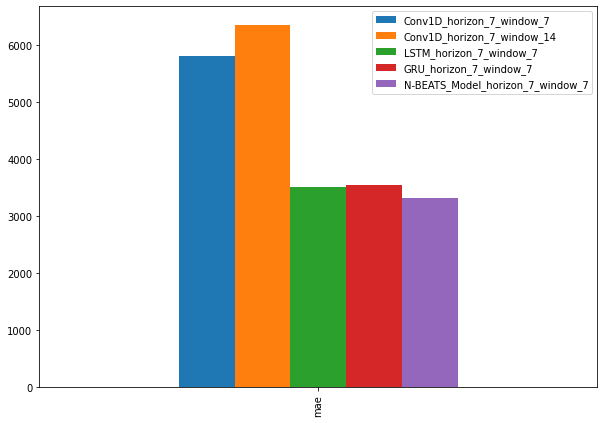

In [ ]:
pd.DataFrame({
              "Conv1D_horizon_7_window_7": model_1_results['mae'],
              "Conv1D_horizon_7_window_14":model_2_results['mae'],
              "LSTM_horizon_7_window_7":model_3_results['mae'],
              "GRU_horizon_7_window_7":model_5_results['mae'],
              "N-BEATS_Model_horizon_7_window_7":model_4_results['mae']}, index=['mae']).plot(figsize = (10,7), kind= 'bar');

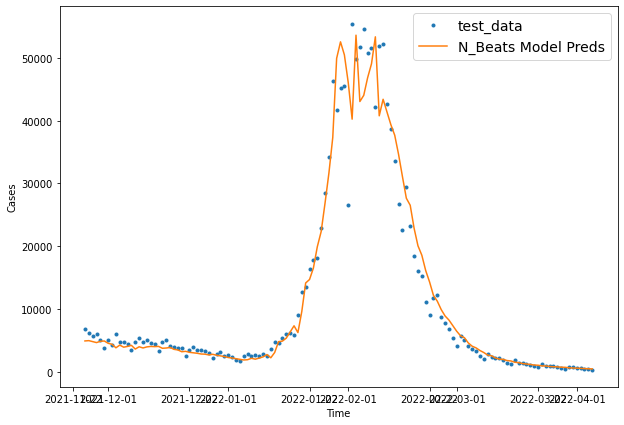

In [ ]:
# Plotting graph for N-Beats model
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:,0],
                 label = 'test_data')
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = tf.reduce_mean(model_4_preds,axis = 1),
                 format = "-",
                 label = 'N_Beats Model Preds')


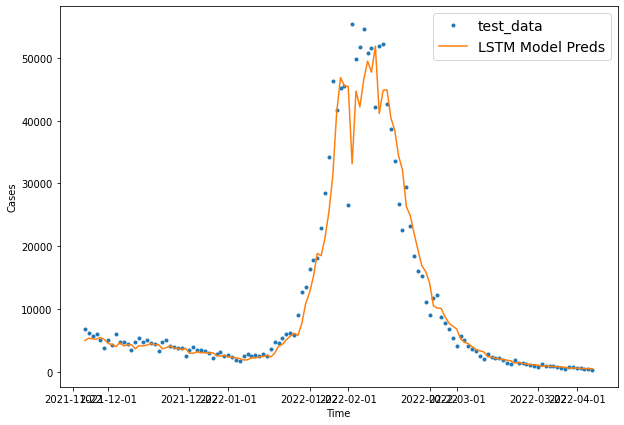

In [ ]:
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:,0],
                 label = 'test_data')
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values =tf.reduce_mean(model_3_preds,axis = 1),
                 format = "-",
                 label = 'LSTM Model Preds')

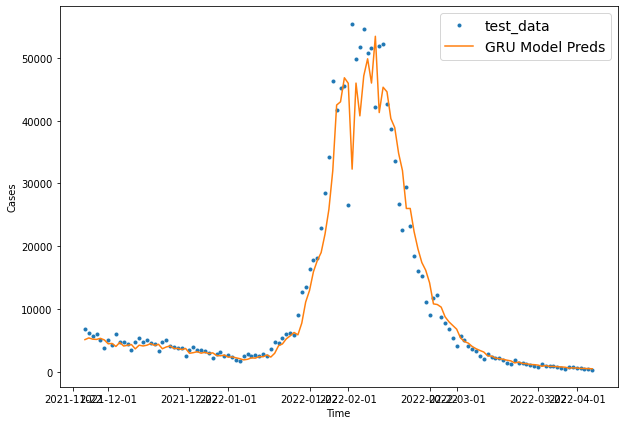

In [ ]:
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:,0],
                 label = 'test_data')
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values =tf.reduce_mean(model_5_preds,axis = 1),
                 format = "-",
                 label = 'GRU Model Preds')

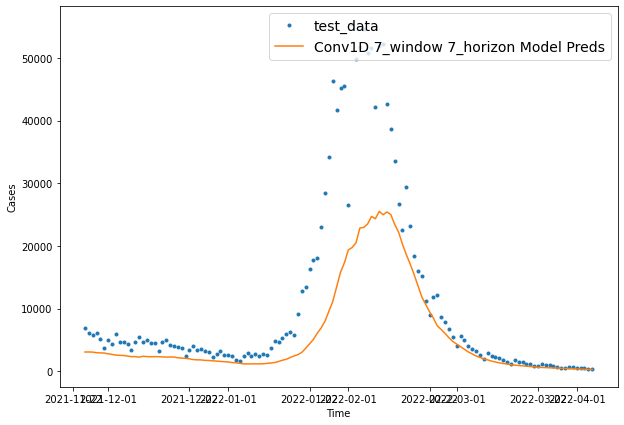

In [ ]:
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:,0],
                 label = 'test_data')
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values =tf.reduce_mean(model_1_preds,axis = 1),
                 format = "-",
                 label = 'Conv1D 7_window 7_horizon Model Preds')

In [ ]:
model_4.name, model_3.name, model_2.name, model_1.name

('model_4_N-Beats', 'model_3_LSTM', 'model_2_Conv1D_14_7', 'model_1_Conv1D')

# History of travel

In [ ]:
import pandas as pd
travel_df = pd.read_csv('/content/contact.csv',)
travel_df.head()

,Date,Contact
0,6-01-2020,4
1,6-02-2020,10
2,6-03-2020,3
3,6-04-2020,15
4,6-05-2020,13


In [ ]:
travel_df['Date'] = pd.to_datetime(travel_df['Date'])
travel_df.head()

,Date,Contact
0,2020-06-01,4
1,2020-06-02,10
2,2020-06-03,3
3,2020-06-04,15
4,2020-06-05,13


In [ ]:
travel_df = travel_df.set_index('Date')
travel_df.head()

,Contact
Date,
2020-06-01,4
2020-06-02,10
2020-06-03,3
2020-06-04,15
2020-06-05,13


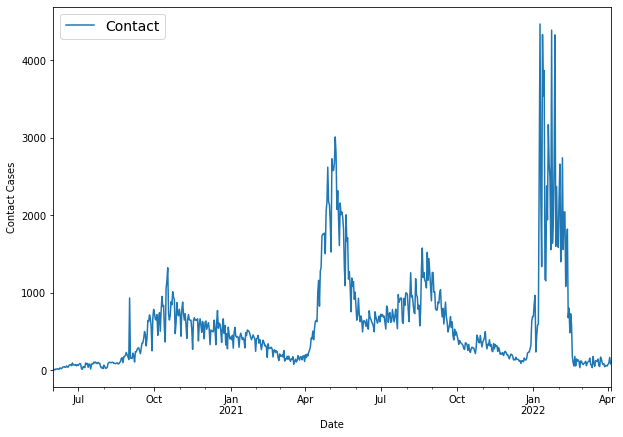

In [ ]:
travel_df.plot(figsize = (10,7))
plt.ylabel("Contact Cases")
plt.legend(fontsize = 14);

In [ ]:
timesteps = travel_df.index.to_numpy()
contacts = travel_df['Contact'].to_numpy()
contacts = contacts.astype(np.float32)

timesteps[:10], contacts[:10]

(array(['2020-06-01T00:00:00.000000000', '2020-06-02T00:00:00.000000000',
        '2020-06-03T00:00:00.000000000', '2020-06-04T00:00:00.000000000',
        '2020-06-05T00:00:00.000000000', '2020-06-06T00:00:00.000000000',
        '2020-06-07T00:00:00.000000000', '2020-06-08T00:00:00.000000000',
        '2020-06-09T00:00:00.000000000', '2020-06-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([ 4., 10.,  3., 15., 13., 18., 13., 11., 29., 21.], dtype=float32))

## Windowing dataset

In [ ]:
split_size = int(len(contacts)*0.8)
X_train,y_train = timesteps[:split_size], contacts[:split_size]
X_test,y_test = timesteps[split_size:], contacts[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(539, 135, 539, 135)

## MODEL 1 : LSTM (window_size = 7, horizon = 7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 7

In [ ]:
full_windows, full_labels = make_windows(contacts,window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(659, 659)

In [ ]:
# Visualize the data
for i in range(5):
    print(f"Windows : {full_windows[i]} -> Label: {full_labels[i]}")

Windows : [ 4. 10.  3. 15. 13. 18. 13.] -> Label: [11. 29. 21. 18. 37. 40. 46.]
Windows : [10.  3. 15. 13. 18. 13. 11.] -> Label: [29. 21. 18. 37. 40. 46. 36.]
Windows : [ 3. 15. 13. 18. 13. 11. 29.] -> Label: [21. 18. 37. 40. 46. 36. 37.]
Windows : [15. 13. 18. 13. 11. 29. 21.] -> Label: [18. 37. 40. 46. 36. 37. 55.]
Windows : [13. 18. 13. 11. 29. 21. 18.] -> Label: [37. 40. 46. 36. 37. 55. 41.]


In [ ]:
train_windows, test_windows, train_labels,test_labels = make_train_test_split(full_windows,full_labels, test_split = 0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(527, 132, 527, 132)

In [ ]:
from tensorflow.keras import layers

In [ ]:
# LSTM Model
tf.random.set_seed(42)

inputs = layers.Input(shape = (WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x,axis = 1))(inputs)
# x = layers.LSTM(128, activation = 'relu', return_sequences = True)(x)
x = layers.LSTM(128, activation = 'relu')(x)
# x = layers.Dense(128,activation = 'relu')(x)
outputs = layers.Dense(HORIZON)(x)
model_hoc_1 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'model_hoc_1_LSTM')

model_hoc_1.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

model_hoc_1.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 32,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_hoc_1.name)])

Epoch 1/100
 9/17 [==============>...............] - ETA: 0s - loss: 574.1133 INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


17/17 [==============================] - 6s 160ms/step - loss: 537.1324 - val_loss: 653.9841
Epoch 2/100
10/17 [================>.............] - ETA: 0s - loss: 427.3386INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


17/17 [==============================] - 2s 127ms/step - loss: 379.0319 - val_loss: 455.2806
Epoch 3/100
10/17 [================>.............] - ETA: 0s - loss: 213.1587INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


17/17 [==============================] - 2s 139ms/step - loss: 185.1282 - val_loss: 407.6213
Epoch 4/100
10/17 [================>.............] - ETA: 0s - loss: 131.0845INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


17/17 [==============================] - 2s 125ms/step - loss: 136.7307 - val_loss: 387.3214
Epoch 5/100
 9/17 [==============>...............] - ETA: 0s - loss: 137.7839INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


17/17 [==============================] - 2s 143ms/step - loss: 132.5821 - val_loss: 381.3801
Epoch 6/100
17/17 [==============================] - 0s 23ms/step - loss: 129.0729 - val_loss: 394.5139
Epoch 7/100
11/17 [==================>...........] - ETA: 0s - loss: 137.1909INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


17/17 [==============================] - 2s 131ms/step - loss: 129.2953 - val_loss: 381.1177
Epoch 8/100
17/17 [==============================] - 0s 9ms/step - loss: 128.9508 - val_loss: 390.9705
Epoch 9/100
 9/17 [==============>...............] - ETA: 0s - loss: 126.2477INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


17/17 [==============================] - 2s 147ms/step - loss: 126.0097 - val_loss: 373.9716
Epoch 10/100
17/17 [==============================] - 0s 9ms/step - loss: 127.5834 - val_loss: 385.0355
Epoch 11/100
17/17 [==============================] - 0s 9ms/step - loss: 124.3885 - val_loss: 376.5855
Epoch 12/100
17/17 [==============================] - 0s 9ms/step - loss: 122.3984 - val_loss: 387.1816
Epoch 13/100
17/17 [==============================] - ETA: 0s - loss: 123.2967INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


17/17 [==============================] - 2s 129ms/step - loss: 123.2967 - val_loss: 372.6215
Epoch 14/100
17/17 [==============================] - 0s 8ms/step - loss: 121.9889 - val_loss: 382.9945
Epoch 15/100
17/17 [==============================] - 0s 8ms/step - loss: 125.3505 - val_loss: 374.8319
Epoch 16/100
17/17 [==============================] - 0s 8ms/step - loss: 123.4363 - val_loss: 373.3741
Epoch 17/100
17/17 [==============================] - 0s 8ms/step - loss: 122.7538 - val_loss: 379.9164
Epoch 18/100
17/17 [==============================] - 0s 8ms/step - loss: 121.9964 - val_loss: 377.1183
Epoch 19/100
17/17 [==============================] - 0s 10ms/step - loss: 120.9996 - val_loss: 376.1577
Epoch 20/100
17/17 [==============================] - 0s 8ms/step - loss: 120.6564 - val_loss: 373.0756
Epoch 21/100
 9/17 [==============>...............] - ETA: 0s - loss: 119.3917INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


17/17 [==============================] - 3s 192ms/step - loss: 120.5441 - val_loss: 370.8516
Epoch 22/100
 9/17 [==============>...............] - ETA: 0s - loss: 120.1381INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_1_LSTM/assets


17/17 [==============================] - 2s 143ms/step - loss: 119.2894 - val_loss: 358.3245
Epoch 23/100
17/17 [==============================] - 0s 8ms/step - loss: 118.3654 - val_loss: 371.7155
Epoch 24/100
17/17 [==============================] - 0s 8ms/step - loss: 119.2761 - val_loss: 363.9969
Epoch 25/100
17/17 [==============================] - 0s 8ms/step - loss: 117.9799 - val_loss: 367.3051
Epoch 26/100
17/17 [==============================] - 0s 9ms/step - loss: 117.4562 - val_loss: 361.8081
Epoch 27/100
17/17 [==============================] - 0s 8ms/step - loss: 117.4879 - val_loss: 367.1798
Epoch 28/100
17/17 [==============================] - 0s 9ms/step - loss: 116.4331 - val_loss: 373.4785
Epoch 29/100
17/17 [==============================] - 0s 8ms/step - loss: 116.7412 - val_loss: 363.3736
Epoch 30/100
17/17 [==============================] - 0s 9ms/step - loss: 116.3947 - val_loss: 371.6117
Epoch 31/100
17/17 [==============================] - 0s 8ms/step - loss: 1

In [ ]:
model_hoc_1 = tf.keras.models.load_model('model_experiments/model_hoc_1_LSTM')
model_hoc_1.evaluate(test_windows,test_labels)

5/5 [==============================] - 0s 6ms/step - loss: 358.3245


358.324462890625

In [ ]:
model_hoc_1_preds = make_preds(model_hoc_1, test_windows)
model_hoc_1_preds[-3:]

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[104.31375 , 108.44754 , 102.78947 ,  88.50891 , 112.61391 ,
        108.542946,  96.258316],
       [ 90.361275,  83.325455,  85.606316,  97.19071 ,  88.5631  ,
         81.214905,  83.186325],
       [ 88.806206,  88.49405 , 100.1151  ,  95.62698 ,  94.60629 ,
         86.89709 ,  88.297966]], dtype=float32)>

In [ ]:
model_hoc_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                     y_pred = model_hoc_1_preds)
model_hoc_1_results

{'mae': 358.32446, 'mape': 68.293365, 'mse': 556281.06, 'rmse': 442.77164}

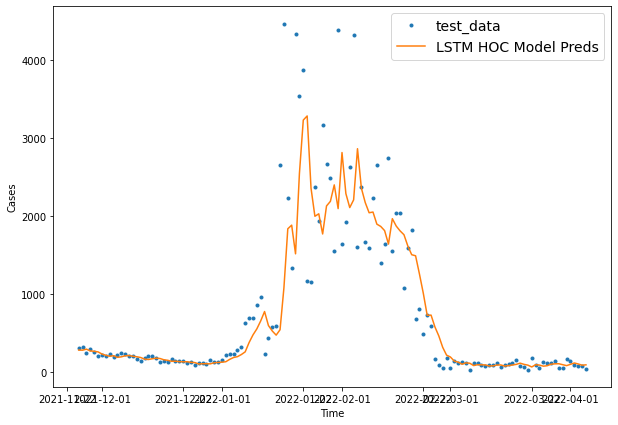

In [ ]:
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:,0],
                 label = 'test_data')
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = tf.reduce_mean(model_hoc_1_preds,axis = 1),
                 format = "-",
                 label = 'LSTM HOC Model Preds')

## MODEL 2: CONV1D (window_size = 7, horizon = 7)

In [ ]:
tf.random.set_seed(42)

model_hoc_2 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,axis = 1)),
    layers.Conv1D(filters = 128, kernel_size = 5, padding = 'causal',activation = 'relu'),
    layers.Dense(HORIZON)
],name = 'model_hoc_2_Conv1D')

model_hoc_2.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

model_hoc_2.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 32,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_hoc_2.name)])

Epoch 1/100
15/17 [=========================>....] - ETA: 0s - loss: 497.4707  INFO:tensorflow:Assets written to: model_experiments/model_hoc_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_2_Conv1D/assets


17/17 [==============================] - 9s 57ms/step - loss: 489.1891 - val_loss: 590.1989
Epoch 2/100
14/17 [=======================>......] - ETA: 0s - loss: 440.6151INFO:tensorflow:Assets written to: model_experiments/model_hoc_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_hoc_2_Conv1D/assets


17/17 [==============================] - 1s 49ms/step - loss: 431.5849 - val_loss: 555.2690
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 428.5047 - val_loss: 560.2703
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 428.0506 - val_loss: 561.5034
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 424.1381 - val_loss: 560.5473
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: 424.7611 - val_loss: 558.4984
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 425.0056 - val_loss: 559.9423
Epoch 8/100
17/17 [==============================] - 0s 7ms/step - loss: 429.0545 - val_loss: 561.8453
Epoch 9/100
17/17 [==============================] - 0s 6ms/step - loss: 427.0261 - val_loss: 558.7966
Epoch 10/100
17/17 [==============================] - 0s 6ms/step - loss: 428.8808 - val_loss: 561.6284
Epoch 11/100
17/17 [==============================] - 0s 6ms/step - loss: 425.6912 

In [ ]:
model_hoc_2 = tf.keras.models.load_model('model_experiments/model_hoc_2_Conv1D')
model_hoc_2.evaluate(test_windows,test_labels)

5/5 [==============================] - 0s 5ms/step - loss: 555.2690


555.26904296875

In [ ]:
model_hoc_2_preds = make_preds(model_hoc_2, test_windows)
model_hoc_2_preds[-3:]

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[66.70249 , 74.81387 , 75.20536 , 64.97716 , 69.60419 , 65.083176,
        68.45166 ],
       [69.013176, 64.62518 , 59.83664 , 71.340195, 63.32046 , 55.909084,
        73.467804],
       [60.196854, 52.20696 , 66.322845, 74.78775 , 50.873196, 62.231575,
        64.59284 ]], dtype=float32)>

In [ ]:
model_hoc_2_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                     y_pred = model_hoc_2_preds)
model_hoc_2_results

{'mae': 386.66418, 'mape': 66.225914, 'mse': 666885.7, 'rmse': 481.93613}

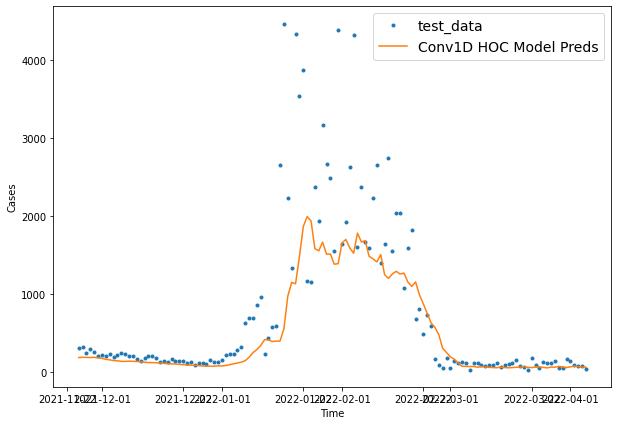

In [ ]:
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:,0],
                #  format = "-",
                 label = 'test_data')
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = tf.reduce_mean(model_hoc_2_preds,axis = 1),
                 format = "-",
                 label = 'Conv1D HOC Model Preds')

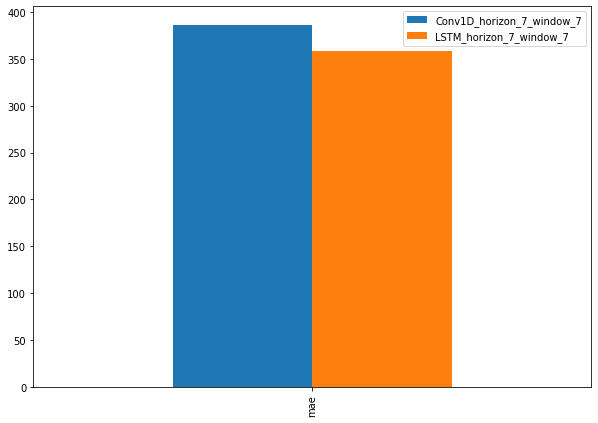

In [ ]:
pd.DataFrame({
              "Conv1D_horizon_7_window_7": model_hoc_2_results['mae'],
              "LSTM_horizon_7_window_7":model_hoc_1_results['mae']}, index=['mae']).plot(figsize = (10,7), kind= 'bar');